# Keras Classification

<span class="girk">We have a dataset in which there are details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.</span>

---
---

## Import  libraries & data

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings

warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV

In [77]:
df = pd.read_csv("Churn_Modelling.csv", index_col='RowNumber')
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


## Exploratory Data Analysis and Visualization

In [78]:
#!pip install pandasgui

In [79]:
from pandasgui import show

gui = show(df)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


In [81]:
df.shape

(10000, 13)

In [82]:
df.isnull().sum().any()

False

In [83]:
df.duplicated().sum()

0

In [84]:
df.describe().T



,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.000,15690940.569,71936.186,15565701.000,15628528.250,15690738.000,15753233.750,15815690.000
CreditScore,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Balance,10000.000,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
NumOfProducts,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
HasCrCard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
IsActiveMember,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
EstimatedSalary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
Exited,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


<AxesSubplot:>

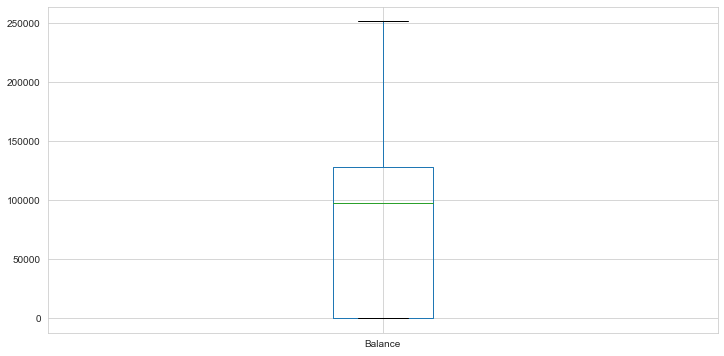

In [85]:
df.Balance.plot(kind="box")

In [86]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

0    7963
1    2037
Name: Exited, dtype: int64


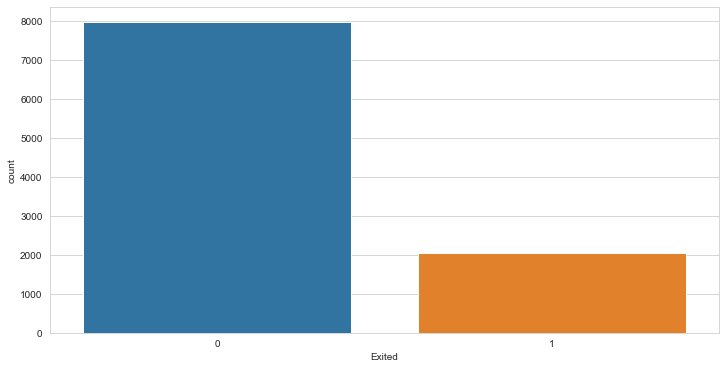

In [87]:
print(df.Exited.value_counts())
sns.countplot(df["Exited"]);

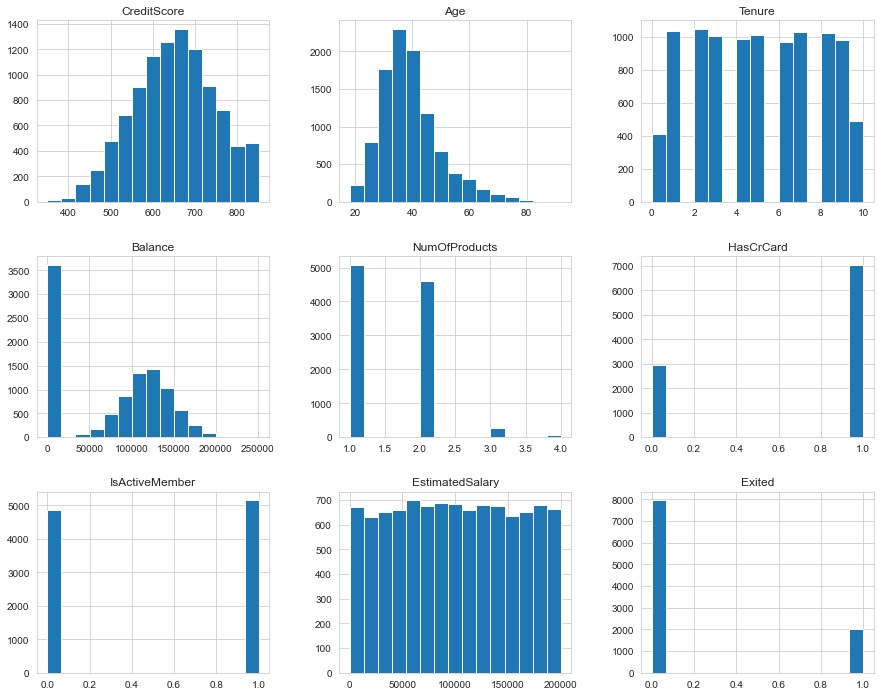

In [88]:
df.hist(figsize=(15, 12), bins=15);


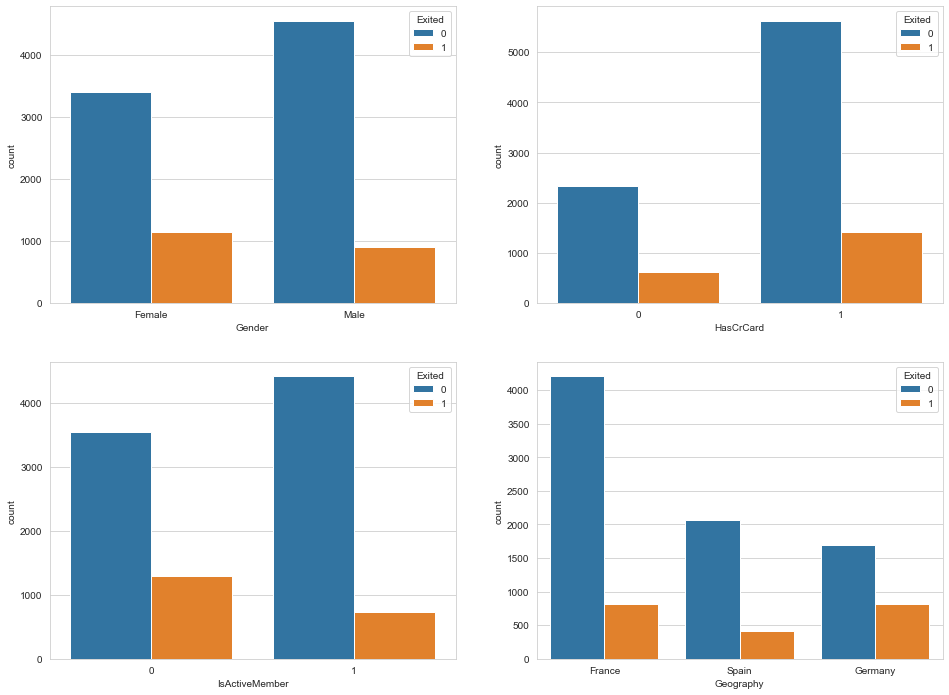

In [89]:
cat_list = ["Gender", "HasCrCard", "IsActiveMember", "Geography"]
index = 0
plt.figure(figsize=(16, 12))
for i in cat_list:
    index += 1
    plt.subplot(2, 2, index)
    sns.countplot(data=df, x=i, hue="Exited")

In [90]:
df.groupby("Age")["Exited"].value_counts()


Age  Exited
18   0         20
     1          2
19   0         26
     1          1
20   0         38
               ..
84   0          1
     1          1
85   0          1
88   0          1
92   0          2
Name: Exited, Length: 128, dtype: int64

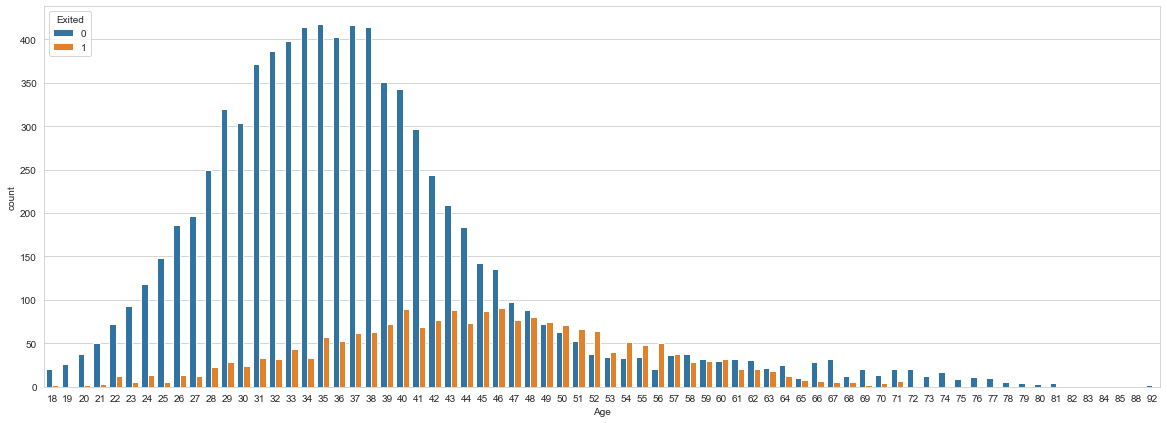

In [91]:
plt.figure(figsize=(20, 7))
sns.countplot(df.Age, hue=df.Exited);

In [92]:
df.CreditScore.describe()

count   10000.000
mean      650.529
std        96.653
min       350.000
25%       584.000
50%       652.000
75%       718.000
max       850.000
Name: CreditScore, dtype: float64

In [93]:
def credit_transformer(x, y):
    if x < 350 and y == 0:
        return 0
    if x < 350 and y > 0:
        return 1
    if x < 718 and y == 0:
        return 2
    if x < 718 and y > 0:
        return 3
    else:
        return 4

In [94]:
customer_value = [
    credit_transformer(x, y) for x, y in zip(df.CreditScore, df.HasCrCard)
]
customer_value[:10]

[3, 2, 3, 2, 4, 3, 4, 3, 2, 3]

In [95]:
df.insert(10, "customer_value", customer_value)

In [96]:
df.customer_value

RowNumber
1        3
2        2
3        3
4        2
5        4
        ..
9996     4
9997     3
9998     2
9999     4
10000    4
Name: customer_value, Length: 10000, dtype: int64

<AxesSubplot:>

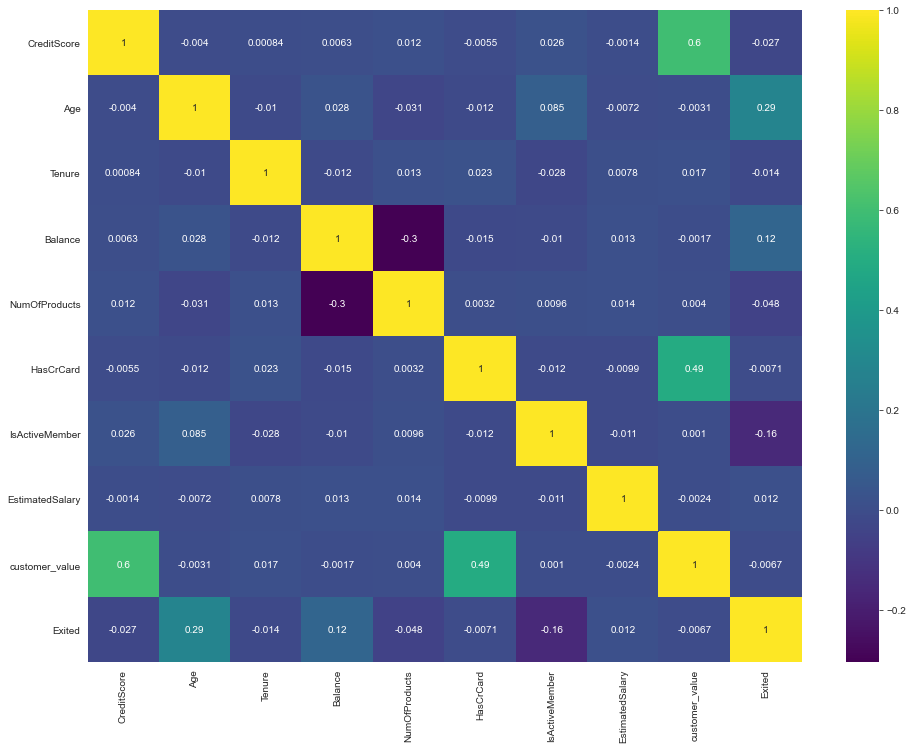

In [97]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

<AxesSubplot:>

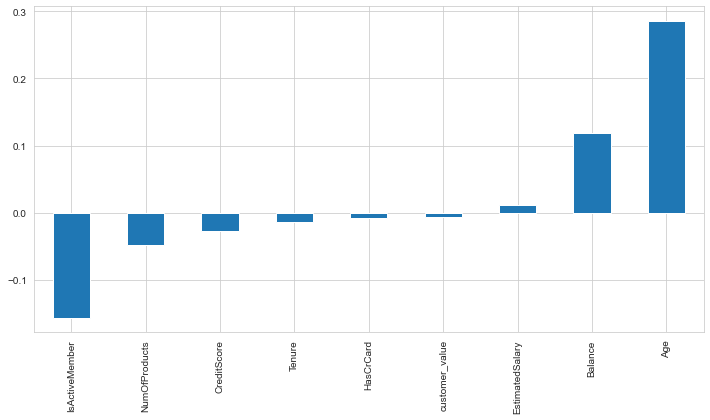

In [98]:
df.corr()['Exited'][:-1].sort_values().plot.bar()

In [99]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,customer_value,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,,
1,619,42,2,0.000,1,1,1,101348.880,3,1,0,0,0
2,608,41,1,83807.860,1,0,1,112542.580,2,0,0,1,0
3,502,42,8,159660.800,3,1,0,113931.570,3,1,0,0,0
4,699,39,1,0.000,2,0,0,93826.630,2,0,0,0,0
5,850,43,2,125510.820,1,1,1,79084.100,4,0,0,1,0


## Preprocessing of Data

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [101]:
X = df.drop('Exited', axis=1)
y = df['Exited'].values

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.1,
                                                    random_state=42)


In [102]:
scaler = MinMaxScaler()


In [103]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling & Model Performance

<span class="mark">How many hidden layers should I use? : http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-9.html (mirror: http://francky.me/aifaq/FAQ-comp.ai.neural-net.pdf)
How many hidden units should I use? : http://www.faqs.org/faqs/ai-faq/neural-nets/part3/section-10.html (mirror: http://francky.me/aifaq/FAQ-comp.ai.neural-net.pdf)
What is genetic algorithm? : https://www.researchgate.net/post/What_is_genetic_algorithm1
Genetic algorithm + neural networks: http://francky.me/doc/mrf2011-HEC-ISIR-ENS_en.pdf (chapter 2.2)</span>

### without class_weigth

In [30]:
model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"])

<span class="burk">The patience is often set somewhere between 10 and 100 (10 or 20 is more common), but it really depends on your dataset and network.</span>

In [31]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=15)

In [32]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop])

Epoch 1/200
64/64 [==============================] - 0s 4ms/step - loss: 0.5855 - recall: 0.0642 - val_loss: 0.5063 - val_recall: 0.0000e+00
Epoch 2/200
64/64 [==============================] - 0s 779us/step - loss: 0.4998 - recall: 0.0000e+00 - val_loss: 0.4814 - val_recall: 0.0000e+00
Epoch 3/200
64/64 [==============================] - 0s 779us/step - loss: 0.4842 - recall: 0.0000e+00 - val_loss: 0.4675 - val_recall: 0.0000e+00
Epoch 4/200
64/64 [==============================] - 0s 810us/step - loss: 0.4749 - recall: 0.0000e+00 - val_loss: 0.4588 - val_recall: 0.0000e+00
Epoch 5/200
64/64 [==============================] - 0s 757us/step - loss: 0.4686 - recall: 0.0000e+00 - val_loss: 0.4518 - val_recall: 0.0000e+00
Epoch 6/200
64/64 [==============================] - 0s 794us/step - loss: 0.4630 - recall: 6.0533e-04 - val_loss: 0.4454 - val_recall: 0.0000e+00
Epoch 7/200
64/64 [==============================] - 0s 841us/step - loss: 0.4582 - recall: 0.0121 - val_loss: 0.4406 - val_

Epoch 59/200
64/64 [==============================] - 0s 748us/step - loss: 0.3463 - recall: 0.4461 - val_loss: 0.3074 - val_recall: 0.5359
Epoch 60/200
64/64 [==============================] - 0s 779us/step - loss: 0.3467 - recall: 0.4389 - val_loss: 0.3064 - val_recall: 0.5470
Epoch 61/200
64/64 [==============================] - 0s 779us/step - loss: 0.3463 - recall: 0.4510 - val_loss: 0.3066 - val_recall: 0.5525
Epoch 62/200
64/64 [==============================] - 0s 795us/step - loss: 0.3467 - recall: 0.4455 - val_loss: 0.3074 - val_recall: 0.5470
Epoch 63/200
64/64 [==============================] - 0s 779us/step - loss: 0.3456 - recall: 0.4528 - val_loss: 0.3085 - val_recall: 0.5470
Epoch 64/200
64/64 [==============================] - 0s 888us/step - loss: 0.3456 - recall: 0.4425 - val_loss: 0.3084 - val_recall: 0.5580
Epoch 65/200
64/64 [==============================] - 0s 779us/step - loss: 0.3455 - recall: 0.4540 - val_loss: 0.3062 - val_recall: 0.5193
Epoch 66/200
64/64 [

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                208       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

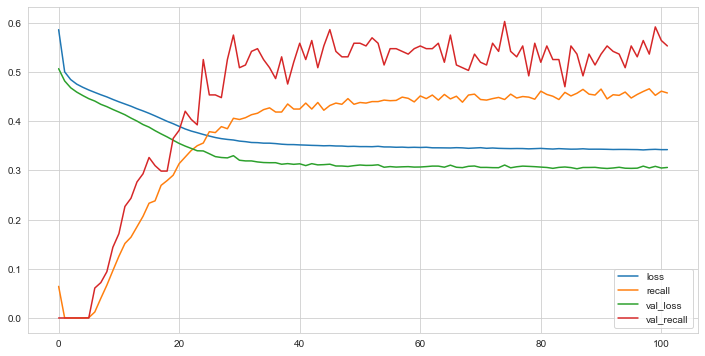

In [34]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [35]:
y_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[765  31]
 [109  95]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       796
           1       0.75      0.47      0.58       204

    accuracy                           0.86      1000
   macro avg       0.81      0.71      0.75      1000
weighted avg       0.85      0.86      0.85      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

Instructions for updating:
Please use `model.predict()` instead.


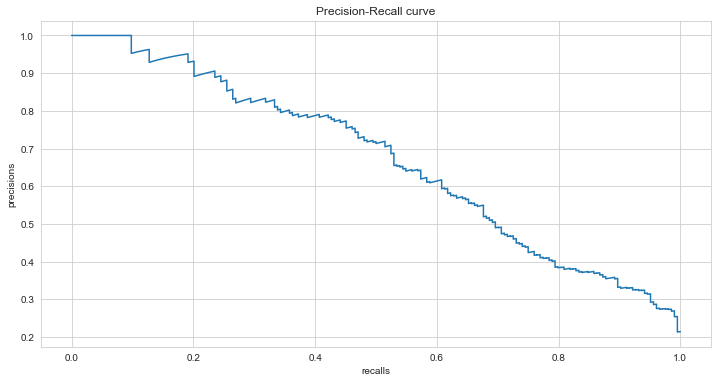

In [36]:
y_pred_proba = model.predict_proba(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [37]:
average_precision_score(y_test, y_pred_proba)

0.6698191000811982

### with class_weigth

In [110]:
# tommy hocanın modeli
model = Sequential()
model.add(Dense(30, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(15, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [38]:
model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

opt = Adam(lr=0.001)
model.compile(optimizer=opt, 
              loss="binary_crossentropy",
              metrics=["Recall"])

In [111]:
early_stop = EarlyStopping(monitor="val_loss",
                           mode="auto",
                           verbose=1,
                           patience=15)

In [112]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [113]:
model.fit(x=X_train,
          y=y_train,
          validation_split=.1,
          batch_size=128,
          epochs=200,
          verbose=1,
          callbacks=[early_stop],
          class_weight=class_weights)

Epoch 1/200
64/64 [==============================] - 0s 3ms/step - loss: 0.7171 - accuracy: 0.5970 - val_loss: 0.6833 - val_accuracy: 0.5322
Epoch 2/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6845 - accuracy: 0.5679 - val_loss: 0.6752 - val_accuracy: 0.5567
Epoch 3/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6797 - accuracy: 0.5725 - val_loss: 0.6717 - val_accuracy: 0.5700
Epoch 4/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6691 - accuracy: 0.5662 - val_loss: 0.6510 - val_accuracy: 0.6200
Epoch 5/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6623 - accuracy: 0.5933 - val_loss: 0.6514 - val_accuracy: 0.6178
Epoch 6/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6602 - accuracy: 0.5773 - val_loss: 0.6493 - val_accuracy: 0.6311
Epoch 7/200
64/64 [==============================] - 0s 1ms/step - loss: 0.6560 - accuracy: 0.5888 - val_loss: 0.6451 - val_accuracy: 0.6422
Epoch 8/200
6

Epoch 59/200
64/64 [==============================] - 0s 1ms/step - loss: 0.5338 - accuracy: 0.7630 - val_loss: 0.4740 - val_accuracy: 0.7889
Epoch 60/200
64/64 [==============================] - 0s 1ms/step - loss: 0.5334 - accuracy: 0.7570 - val_loss: 0.4893 - val_accuracy: 0.7756
Epoch 61/200
64/64 [==============================] - 0s 1ms/step - loss: 0.5409 - accuracy: 0.7498 - val_loss: 0.4924 - val_accuracy: 0.7867
Epoch 62/200
64/64 [==============================] - 0s 1ms/step - loss: 0.5388 - accuracy: 0.7556 - val_loss: 0.4718 - val_accuracy: 0.7922
Epoch 63/200
64/64 [==============================] - 0s 1ms/step - loss: 0.5298 - accuracy: 0.7599 - val_loss: 0.4712 - val_accuracy: 0.7878
Epoch 64/200
64/64 [==============================] - 0s 1ms/step - loss: 0.5325 - accuracy: 0.7556 - val_loss: 0.4743 - val_accuracy: 0.7822
Epoch 65/200
64/64 [==============================] - 0s 1ms/step - loss: 0.5294 - accuracy: 0.7569 - val_loss: 0.4663 - val_accuracy: 0.7867
Epoch 

<AxesSubplot:>

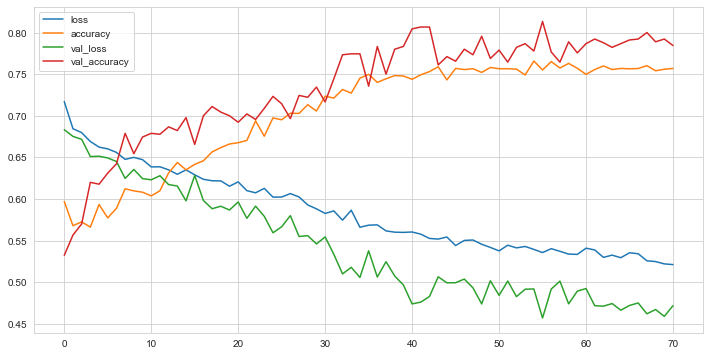

In [114]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [115]:
y_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[596 200]
 [ 47 157]]
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       796
           1       0.44      0.77      0.56       204

    accuracy                           0.75      1000
   macro avg       0.68      0.76      0.69      1000
weighted avg       0.83      0.75      0.77      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for model

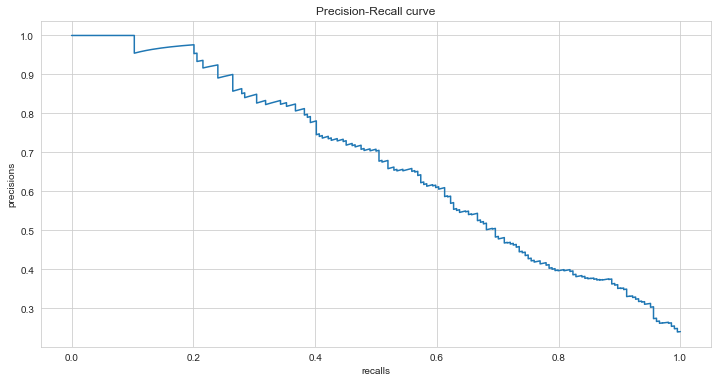

In [44]:
y_pred_proba = model.predict_proba(X_test)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [45]:
average_precision_score(y_test, y_pred_proba)

0.6726066367790163

## GridSearchCV

In [46]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [47]:
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units=16, activation='relu'))
    classifier.add(Dense(units=8, activation='relu'))
    classifier.add(Dense(units=1, activation='sigmoid'))
    classifier.compile(optimizer=optimizer,
                       loss='binary_crossentropy',
                       metrics=['Recall'])
    return classifier

In [48]:
class_weights

{0: 0.6278777731268314, 1: 2.454991816693944}

In [49]:
classifier = KerasClassifier(build_fn=build_classifier, epochs=150)
parameters = {
    'batch_size': [128, 256],
    'optimizer': [Adam, 'rmsprop', "SGD", "adagrad", "adadelta"]
}
grid_model = GridSearchCV(estimator=classifier,
                          param_grid=parameters,
                          scoring='recall',
                          cv=5,
                          n_jobs=-1,
                          verbose=0).fit(X_train,
                                         y_train,
                                         class_weight=class_weights)

Epoch 1/150
36/36 [==============================] - 0s 720us/step - loss: 0.6843 - recall: 0.2548
Epoch 2/150
36/36 [==============================] - 0s 803us/step - loss: 0.6745 - recall: 0.4441
Epoch 3/150
36/36 [==============================] - 0s 748us/step - loss: 0.6607 - recall: 0.5537
Epoch 4/150
36/36 [==============================] - 0s 803us/step - loss: 0.6480 - recall: 0.6187
Epoch 5/150
36/36 [==============================] - 0s 748us/step - loss: 0.6390 - recall: 0.6503
Epoch 6/150
36/36 [==============================] - 0s 859us/step - loss: 0.6322 - recall: 0.6694
Epoch 7/150
36/36 [==============================] - 0s 720us/step - loss: 0.6268 - recall: 0.6716
Epoch 8/150
36/36 [==============================] - 0s 637us/step - loss: 0.6219 - recall: 0.6754
Epoch 9/150
36/36 [==============================] - 0s 609us/step - loss: 0.6176 - recall: 0.6819
Epoch 10/150
36/36 [==============================] - 0s 637us/step - loss: 0.6135 - recall: 0.6869
Epoch 11/

36/36 [==============================] - 0s 665us/step - loss: 0.4753 - recall: 0.7583
Epoch 82/150
36/36 [==============================] - 0s 637us/step - loss: 0.4755 - recall: 0.7714
Epoch 83/150
36/36 [==============================] - 0s 666us/step - loss: 0.4750 - recall: 0.7512
Epoch 84/150
36/36 [==============================] - 0s 665us/step - loss: 0.4747 - recall: 0.7578
Epoch 85/150
36/36 [==============================] - 0s 693us/step - loss: 0.4737 - recall: 0.7632
Epoch 86/150
36/36 [==============================] - 0s 582us/step - loss: 0.4738 - recall: 0.7578
Epoch 87/150
36/36 [==============================] - 0s 665us/step - loss: 0.4727 - recall: 0.7589
Epoch 88/150
36/36 [==============================] - 0s 637us/step - loss: 0.4731 - recall: 0.7496
Epoch 89/150
36/36 [==============================] - 0s 637us/step - loss: 0.4725 - recall: 0.7703
Epoch 90/150
36/36 [==============================] - 0s 637us/step - loss: 0.4722 - recall: 0.7540
Epoch 91/150


In [50]:
grid_model.best_score_

0.7203420514278609

In [51]:
grid_model.best_params_

{'batch_size': 256, 'optimizer': 'rmsprop'}

In [52]:
y_pred = grid_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[556 240]
 [ 40 164]]
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       796
           1       0.41      0.80      0.54       204

    accuracy                           0.72      1000
   macro avg       0.67      0.75      0.67      1000
weighted avg       0.83      0.72      0.75      1000



### ROC (Receiver Operating Curve) and AUC (Area Under Curve) for grid_model

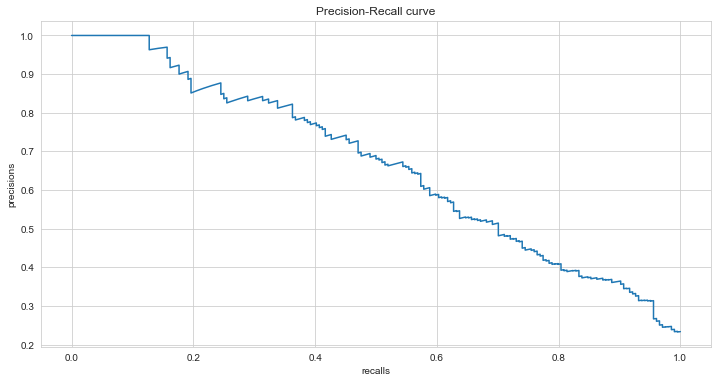

In [53]:
y_pred_proba = grid_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='ANN')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [54]:
average_precision_score(y_test, y_pred_proba)

0.664750192842897

## Final Model and Model Deployment

In [55]:
import pickle

pickle.dump(scaler, open("scaler_churn", 'wb'))

In [56]:
model = Sequential()

model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["Recall"])

model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test, y_test),
          callbacks=[early_stop],
          batch_size=128,
          epochs=200,
          verbose=1,
          class_weight=class_weights)

Epoch 1/200
71/71 [==============================] - 0s 3ms/step - loss: 0.6995 - recall: 0.3415 - val_loss: 0.6982 - val_recall: 0.5833
Epoch 2/200
71/71 [==============================] - 0s 840us/step - loss: 0.6749 - recall: 0.6279 - val_loss: 0.6877 - val_recall: 0.6029
Epoch 3/200
71/71 [==============================] - 0s 871us/step - loss: 0.6537 - recall: 0.6465 - val_loss: 0.6631 - val_recall: 0.6275
Epoch 4/200
71/71 [==============================] - 0s 899us/step - loss: 0.6357 - recall: 0.6492 - val_loss: 0.6307 - val_recall: 0.5833
Epoch 5/200
71/71 [==============================] - 0s 801us/step - loss: 0.6229 - recall: 0.6628 - val_loss: 0.6171 - val_recall: 0.5931
Epoch 6/200
71/71 [==============================] - 0s 773us/step - loss: 0.6136 - recall: 0.6623 - val_loss: 0.6345 - val_recall: 0.6422
Epoch 7/200
71/71 [==============================] - 0s 773us/step - loss: 0.6056 - recall: 0.6852 - val_loss: 0.5938 - val_recall: 0.6078
Epoch 8/200
71/71 [==========

71/71 [==============================] - 0s 745us/step - loss: 0.4681 - recall: 0.7600 - val_loss: 0.4806 - val_recall: 0.7598
Epoch 60/200
71/71 [==============================] - 0s 787us/step - loss: 0.4664 - recall: 0.7632 - val_loss: 0.4397 - val_recall: 0.7255
Epoch 61/200
71/71 [==============================] - 0s 759us/step - loss: 0.4671 - recall: 0.7561 - val_loss: 0.4431 - val_recall: 0.7157
Epoch 62/200
71/71 [==============================] - 0s 787us/step - loss: 0.4665 - recall: 0.7578 - val_loss: 0.4680 - val_recall: 0.7451
Epoch 63/200
71/71 [==============================] - 0s 773us/step - loss: 0.4664 - recall: 0.7523 - val_loss: 0.4764 - val_recall: 0.7598
Epoch 64/200
71/71 [==============================] - 0s 744us/step - loss: 0.4665 - recall: 0.7501 - val_loss: 0.5065 - val_recall: 0.7990
Epoch 65/200
71/71 [==============================] - 0s 759us/step - loss: 0.4658 - recall: 0.7605 - val_loss: 0.4679 - val_recall: 0.7549
Epoch 00065: early stopping


<AxesSubplot:>

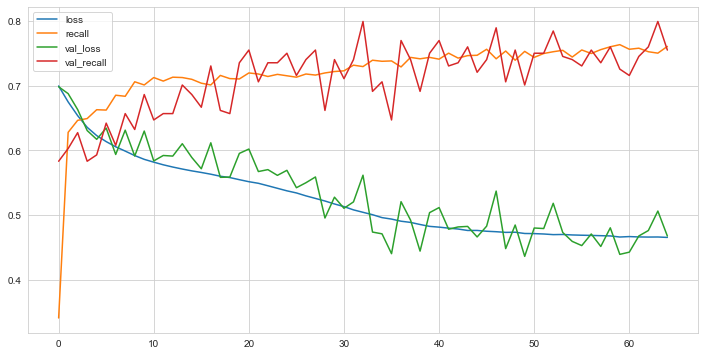

In [57]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [58]:
y_pred = model.predict_classes(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[620 176]
 [ 50 154]]
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       796
           1       0.47      0.75      0.58       204

    accuracy                           0.77      1000
   macro avg       0.70      0.77      0.71      1000
weighted avg       0.83      0.77      0.79      1000



In [59]:
model.save('model_churn.h5')

### Prediction

In [60]:
single_customer = df.drop('Exited', axis=1).iloc[0]
single_customer

CreditScore            619.000
Age                     42.000
Tenure                   2.000
Balance                  0.000
NumOfProducts            1.000
HasCrCard                1.000
IsActiveMember           1.000
EstimatedSalary     101348.880
customer_value           3.000
Geography_Germany        0.000
Geography_Spain          0.000
Gender_Male              0.000
Name: 1, dtype: float64

In [61]:
single_customer = scaler.transform(single_customer.values.reshape(-1, 12))
single_customer

array([[0.538     , 0.32432432, 0.2       , 0.        , 0.        ,
        1.        , 1.        , 0.50673489, 0.5       , 0.        ,
        0.        , 0.        ]])

In [62]:
model.predict_classes(single_customer)

array([[1]])

In [63]:
df["Exited"].iloc[0]

1

---
---

## Comparison with ML

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [65]:
clf1 = RandomForestClassifier(random_state=42, class_weight="balanced")
clf2 = SVC(probability=True, random_state=42, class_weight="balanced")
clf3 = LogisticRegression(random_state=42, class_weight="balanced")

In [74]:
[10**(-2+i) for i in range(5)]

[0.01, 0.1, 1, 10, 100]

In [66]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**(-2+i) for i in range(5)]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**(-2+i) for i in range(5)]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier'] = [clf3]

In [67]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3]

In [68]:
grid_model = GridSearchCV(pipeline, params, cv=5, n_jobs=-1,
                  scoring='recall').fit(X_train, y_train)

In [69]:
grid_model.best_params_

{'classifier': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=250,
                        random_state=42),
 'classifier__max_depth': 5,
 'classifier__n_estimators': 250}

In [70]:
grid_model.best_score_

0.7141272464674439

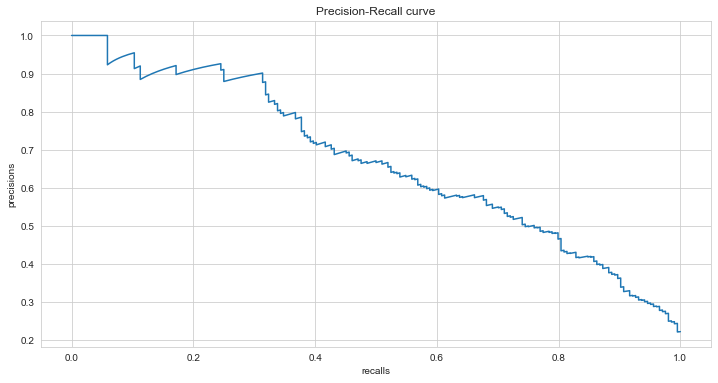

In [71]:
y_pred_proba = grid_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, label='RF')
plt.xlabel('recalls')
plt.ylabel('precisions')
plt.title('Precision-Recall curve')
plt.show()

In [72]:
average_precision_score(y_test, y_pred_proba)

0.6703619323498627

In [73]:
y_pred = grid_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[643 153]
 [ 52 152]]
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       796
           1       0.50      0.75      0.60       204

    accuracy                           0.80      1000
   macro avg       0.71      0.78      0.73      1000
weighted avg       0.84      0.80      0.81      1000



---
---